In [1]:
import os
import zlib
import numpy as np
import PIL.Image as Image
from IPython.display import display

import torch
import torch.nn as nn
from torchvision import transforms

from vector_quantize_pytorch import FSQ

In [2]:
def pil_to_pt(img):
    t = transforms.functional.pil_to_tensor(img)
    t = t.to(torch.float)
    t = t/255
    t = t-0.5
    t = t.unsqueeze(0)
    return t
def pt_to_pil(t):
    t = t+0.5
    t = t*255
    t = torch.clamp(t, min=-0.49, max=255.49)
    t = t.round()
    t = t.to(torch.uint8)
    return t

In [3]:
class VectorQuantizedAutoencoder(nn.Module):
    def __init__(self, levels): 
        super().__init__()
        
        self.analysis_transform = nn.Sequential(
            nn.Conv2d(3, 192, kernel_size=2, stride=1, padding=1),
            nn.Conv2d(192, 192, kernel_size=6, stride=3, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.GELU(),
            nn.Conv2d(192, 192, kernel_size=6, stride=3, padding=1),
            nn.Conv2d(192, 512, kernel_size=6, stride=3, padding=1),
        )
        
        self.fsq = FSQ(levels)
        
        self.synthesis_transform = nn.Sequential(
            nn.ConvTranspose2d(512, 192, kernel_size=6, stride=3, padding=1),
            nn.ConvTranspose2d(192, 192, kernel_size=6, stride=3, padding=0),
            nn.GELU(),
            nn.Upsample(scale_factor=2, mode="nearest"),
            nn.ConvTranspose2d(192, 192, kernel_size=6, stride=3, padding=0),
            nn.Conv2d(192, 3, kernel_size=2, stride=1, padding=1),
        )

    def forward(self, x):
        x = self.analysis_transform(x)
        x, indices = self.fsq(x)
        x = self.synthesis_transform(x)

        return x.clamp(-1, 1), indices

In [4]:
# def lossy_analysis_transform(img):
#     x = pil_to_pt(img)
#     z,indices = net(x)
#     indices = indices.to(torch.int8).detach().to("cpu").numpy()
#     return z,indices
    
# def lossless_entropy_encode(z,indices):
#     original_shape = z.shape
#     compressed_img = zlib.compress(indices.tobytes(), level=9)
#     return compressed_img, original_shape

# def compress(img):
#     z,indices = lossy_analysis_transform(img)
#     compressed_img, original_shape = lossless_entropy_encode(z,indices)
#     return compressed_img, original_shape

In [5]:
# def entropy_decoder(compressed_img,original_shape):
#     decompressed = zlib.decompress(compressed_img)
#     indices = np.frombuffer(decompressed, dtype=np.int8)
#     return ẑ

In [6]:
net = VectorQuantizedAutoencoder(levels=[8, 5, 5, 5])
checkpoint = torch.load("vqvae_vimeo_checkpoint.pth")
net.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [7]:
img = Image.open("kodim05.png");
img.save("kodim05.jpg", "JPEG", quality=5)
jpeg = Image.open("kodim05.jpg");

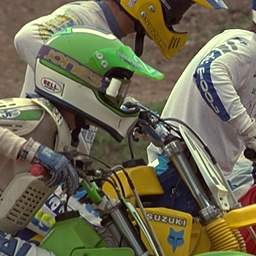

In [8]:
crop = img.crop((12,12,268,268))
display(crop)
x = pil_to_pt(crop)

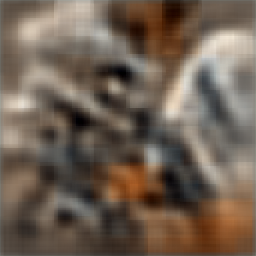

In [9]:
z = net.analysis_transform(x)
_, indices = net.fsq(z)
ẑ = net.fsq.indices_to_codes(indices)
x̂ = net.synthesis_transform(ẑ)
display(transforms.ToPILImage()(pt_to_pil(x̂)[0]))

In [14]:
256*256*3*8/(512*4*10)

76.8

In [ ]:
compressed_img, original_shape = compress(img);
print("Bytes in compressed image (excluding codebook):", len(compressed_img))
x̂,indices = lossy_analysis_transform(img)

In [ ]:
print('original image');
display(img)
print("JPEG compression ratio", (3*512*768)/os.path.getsize('kodim05.jpg'))
display(jpeg);
print("VQVAE compression ratio (excluding codebook)", (3*512*768)/len(compressed_img))
display(transforms.ToPILImage()(pt_to_pil(x̂)[0]))

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4),dpi=400)
histogram = torch.histogram(torch.tensor(indices).to(torch.float),bins=256, range=(-128.5,127.5))
x = np.convolve(histogram.bin_edges,[0.5,0.5])[1:-1]
y = np.log(1+histogram.hist)
plt.bar(x,y);